In [2]:
from utils import lr_finder, learner, validate, MyIterator
from get_dataset import get_dataset
import random
import time
import os
import torch
import torch.nn as nn
from torch.optim import Adam
from importlib import reload

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# If you have dark theme
from matplotlib.pyplot import rcParams
rcParams['figure.facecolor'] = 'white'

In [4]:
# Setup logger
import logging
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s : %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [86]:
dataset, emb_weights = get_dataset()
# dataset.fields['review'].include_lengths = True

random.seed(43)
ds_train, ds_val, ds_test = dataset.split(split_ratio=[0.8, 0.1, 0.1], random_state=random.getstate())

05/07/2020 03:03:48 PM INFO : Downloading data
05/07/2020 03:03:49 PM INFO : Downloading GloVe word vectors
05/07/2020 03:03:49 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt
05/07/2020 03:03:58 PM INFO : Loading vectors from .vector_cache/glove.6B.300d.txt.pt


<br>

In [317]:
class CNN(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()

        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(1, out_channels, (kernel_heights[1], self.embedding_length), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(1, out_channels, (kernel_heights[2], self.embedding_length), stride, (padding[2], 0))
        self.conv4 = nn.Conv2d(1, out_channels, (kernel_heights[3], self.embedding_length), stride, (padding[3], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(len(kernel_heights)*out_channels, 2)

    def conv_block(self, input, conv_layer):
        conv_out = conv_layer(input)# conv_out.size() = (batch_size, out_channels, dim, 1)
        activation = self.relu(conv_out.squeeze(3))# activation.size() = (batch_size, out_channels, dim1)
        max_out = nn.functional.max_pool1d(activation, activation.size()[2]).squeeze(2)# maxpool_out.size() = (batch_size, out_channels)

        return max_out

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)

        max_out1 = self.conv_block(self.dropout0(input), self.conv1)
        max_out2 = self.conv_block(self.dropout0(input), self.conv2)
        max_out3 = self.conv_block(self.dropout0(input), self.conv3)
        max_out4 = self.conv_block(self.dropout0(input), self.conv4)
        all_out = torch.cat((max_out1, max_out2, max_out3, max_out4), 1)

        return self.head(self.dropout1(all_out))

In [190]:
model = CNN(out_channels=16, kernel_heights=(1, 3, 5, 7), stride=1, padding=(0, 1, 2, 3), dropout=(0.4, 0.4), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)

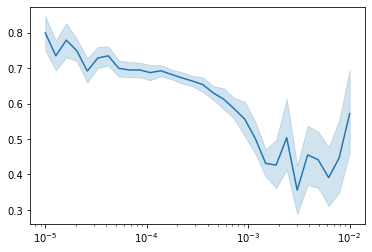

In [89]:
optimiser = Adam(model.parameters())
lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-5, 1e-2], bs=8, avg_over_batches=30)

In [191]:
optimiser = Adam(model.parameters(), lr=3e-4)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=8, bs=8)

05/07/2020 04:01:40 PM INFO : Epoch : 1, batch : 100, train_loss = 0.6792, val_loss = 0.6629, val_accuracy : 0.550, time = 1s
05/07/2020 04:01:41 PM INFO : Epoch : 1, batch : 200, train_loss = 0.6404, val_loss = 0.6134, val_accuracy : 0.757, time = 2s
05/07/2020 04:01:41 PM INFO : Epoch : 1, batch : 300, train_loss = 0.6065, val_loss = 0.5665, val_accuracy : 0.773, time = 3s
05/07/2020 04:01:42 PM INFO : Epoch : 2, batch : 100, train_loss = 0.5520, val_loss = 0.5389, val_accuracy : 0.740, time = 3s
05/07/2020 04:01:43 PM INFO : Epoch : 2, batch : 200, train_loss = 0.4886, val_loss = 0.4708, val_accuracy : 0.810, time = 4s
05/07/2020 04:01:44 PM INFO : Epoch : 2, batch : 300, train_loss = 0.4592, val_loss = 0.4344, val_accuracy : 0.817, time = 5s
05/07/2020 04:01:45 PM INFO : Epoch : 3, batch : 100, train_loss = 0.4462, val_loss = 0.4334, val_accuracy : 0.807, time = 6s
05/07/2020 04:01:46 PM INFO : Epoch : 3, batch : 200, train_loss = 0.3964, val_loss = 0.3865, val_accuracy : 0.843, ti

In [192]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/07/2020 04:02:05 PM INFO : Epoch : 1, batch : 100, train_loss = 0.2239, val_loss = 0.2980, val_accuracy : 0.883, time = 2s
05/07/2020 04:02:06 PM INFO : Epoch : 1, batch : 200, train_loss = 0.2173, val_loss = 0.2968, val_accuracy : 0.873, time = 3s
05/07/2020 04:02:07 PM INFO : Epoch : 1, batch : 300, train_loss = 0.2138, val_loss = 0.2995, val_accuracy : 0.877, time = 4s
05/07/2020 04:02:08 PM INFO : Epoch : 2, batch : 100, train_loss = 0.2327, val_loss = 0.2978, val_accuracy : 0.880, time = 5s
05/07/2020 04:02:10 PM INFO : Epoch : 2, batch : 200, train_loss = 0.2074, val_loss = 0.2959, val_accuracy : 0.883, time = 7s
05/07/2020 04:02:11 PM INFO : Epoch : 2, batch : 300, train_loss = 0.2195, val_loss = 0.2953, val_accuracy : 0.887, time = 8s
05/07/2020 04:02:12 PM INFO : Epoch : 3, batch : 100, train_loss = 0.2161, val_loss = 0.2957, val_accuracy : 0.870, time = 9s
05/07/2020 04:02:13 PM INFO : Epoch : 3, batch : 200, train_loss = 0.2014, val_loss = 0.2935, val_accuracy : 0.883, ti

In [193]:
model.word_embeddings.weight.requires_grad_(True);
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/07/2020 04:02:18 PM INFO : Epoch : 1, batch : 100, train_loss = 0.2122, val_loss = 0.2915, val_accuracy : 0.873, time = 3s
05/07/2020 04:02:21 PM INFO : Epoch : 1, batch : 200, train_loss = 0.1978, val_loss = 0.2872, val_accuracy : 0.883, time = 6s
05/07/2020 04:02:24 PM INFO : Epoch : 1, batch : 300, train_loss = 0.1936, val_loss = 0.2882, val_accuracy : 0.880, time = 8s
05/07/2020 04:02:27 PM INFO : Epoch : 2, batch : 100, train_loss = 0.2012, val_loss = 0.2854, val_accuracy : 0.880, time = 11s
05/07/2020 04:02:30 PM INFO : Epoch : 2, batch : 200, train_loss = 0.1922, val_loss = 0.2849, val_accuracy : 0.880, time = 14s
05/07/2020 04:02:32 PM INFO : Epoch : 2, batch : 300, train_loss = 0.1917, val_loss = 0.2815, val_accuracy : 0.883, time = 17s
05/07/2020 04:02:35 PM INFO : Epoch : 3, batch : 100, train_loss = 0.1793, val_loss = 0.2808, val_accuracy : 0.877, time = 19s
05/07/2020 04:02:37 PM INFO : Epoch : 3, batch : 200, train_loss = 0.1565, val_loss = 0.2803, val_accuracy : 0.890

In [194]:
optimiser.param_groups[0]['lr'] = 5e-5
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/07/2020 04:02:42 PM INFO : Epoch : 1, batch : 100, train_loss = 0.1662, val_loss = 0.2785, val_accuracy : 0.890, time = 2s
05/07/2020 04:02:45 PM INFO : Epoch : 1, batch : 200, train_loss = 0.1488, val_loss = 0.2778, val_accuracy : 0.890, time = 5s
05/07/2020 04:02:47 PM INFO : Epoch : 1, batch : 300, train_loss = 0.1677, val_loss = 0.2790, val_accuracy : 0.893, time = 7s
05/07/2020 04:02:50 PM INFO : Epoch : 2, batch : 100, train_loss = 0.1561, val_loss = 0.2764, val_accuracy : 0.887, time = 10s
05/07/2020 04:02:52 PM INFO : Epoch : 2, batch : 200, train_loss = 0.1473, val_loss = 0.2757, val_accuracy : 0.887, time = 12s
05/07/2020 04:02:54 PM INFO : Epoch : 2, batch : 300, train_loss = 0.1598, val_loss = 0.2761, val_accuracy : 0.893, time = 15s
05/07/2020 04:02:57 PM INFO : Epoch : 3, batch : 100, train_loss = 0.1433, val_loss = 0.2752, val_accuracy : 0.887, time = 17s
05/07/2020 04:02:59 PM INFO : Epoch : 3, batch : 200, train_loss = 0.1379, val_loss = 0.2764, val_accuracy : 0.893

In [195]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.23483, test accuracy : 0.890


<br>

In [318]:
class CNN2(nn.Module):
    def __init__(self, out_channels, kernel_heights, stride, padding, dropout, emb_weights):
        super().__init__()
        
        self.out_channels = out_channels
        self.kernel_heights = kernel_heights
        self.stride = stride
        self.padding = padding
        self.embedding_length = emb_weights.shape[1]

        self.word_embeddings = nn.Embedding.from_pretrained(emb_weights)
        self.conv1 = nn.Conv2d(1, out_channels, (kernel_heights[0], self.embedding_length), stride, (padding[0], 0))
        self.conv2 = nn.Conv2d(out_channels, 2*out_channels, (kernel_heights[1], 1), stride, (padding[1], 0))
        self.conv3 = nn.Conv2d(2*out_channels, 4*out_channels, (kernel_heights[2], 1), stride, (padding[2], 0))
        self.dropout0 = nn.Dropout(p=dropout[0])
        self.dropout1 = nn.Dropout(p=dropout[1])
        self.relu = nn.ReLU()
        self.head = nn.Linear(4*out_channels, 2)

    def forward(self, batch):
        input = self.word_embeddings(batch).unsqueeze(1)
        # input.size() = (batch_size, 1, num_seq, embedding_length)
        
        out = self.relu(self.conv1(self.dropout0(input)))
        out = self.relu(self.conv2(self.dropout0(out)))
        out = self.relu(self.conv3(self.dropout0(out)))
        max_out = max_out = nn.functional.max_pool1d(out.squeeze(3), out.size()[2]).squeeze(2)

        return self.head(self.dropout1(max_out))

In [310]:
model = CNN2(out_channels=32, kernel_heights=(1, 3, 5), stride=1, padding=(0, 1, 2), dropout=(0.2, 0.3), emb_weights=emb_weights.clone())
loss_fn = nn.CrossEntropyLoss().to(device)

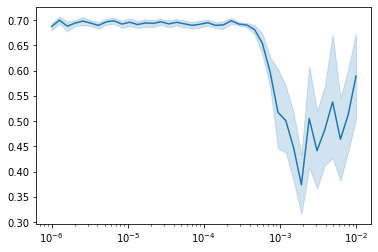

In [304]:
optimiser = Adam(model.parameters())
lr_finder(model, ds_train, optimiser, loss_fn, lr_range=[1e-6, 1e-2], bs=8, avg_over_batches=30)

In [311]:
optimiser = Adam(model.parameters(), lr=3e-4)
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=8, bs=8)

05/07/2020 04:53:21 PM INFO : Epoch : 1, batch : 100, train_loss = 0.6950, val_loss = 0.6930, val_accuracy : 0.473, time = 1s
05/07/2020 04:53:22 PM INFO : Epoch : 1, batch : 200, train_loss = 0.6926, val_loss = 0.6878, val_accuracy : 0.593, time = 2s
05/07/2020 04:53:23 PM INFO : Epoch : 1, batch : 300, train_loss = 0.6761, val_loss = 0.6394, val_accuracy : 0.693, time = 3s
05/07/2020 04:53:24 PM INFO : Epoch : 2, batch : 100, train_loss = 0.5741, val_loss = 0.4799, val_accuracy : 0.807, time = 4s
05/07/2020 04:53:25 PM INFO : Epoch : 2, batch : 200, train_loss = 0.4570, val_loss = 0.4010, val_accuracy : 0.823, time = 5s
05/07/2020 04:53:26 PM INFO : Epoch : 2, batch : 300, train_loss = 0.4396, val_loss = 0.3759, val_accuracy : 0.833, time = 7s
05/07/2020 04:53:28 PM INFO : Epoch : 3, batch : 100, train_loss = 0.4137, val_loss = 0.3671, val_accuracy : 0.853, time = 8s
05/07/2020 04:53:29 PM INFO : Epoch : 3, batch : 200, train_loss = 0.3496, val_loss = 0.3411, val_accuracy : 0.847, ti

In [312]:
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8)

05/07/2020 04:53:53 PM INFO : Epoch : 1, batch : 100, train_loss = 0.2599, val_loss = 0.2779, val_accuracy : 0.887, time = 1s
05/07/2020 04:53:54 PM INFO : Epoch : 1, batch : 200, train_loss = 0.2380, val_loss = 0.2701, val_accuracy : 0.890, time = 3s
05/07/2020 04:53:56 PM INFO : Epoch : 1, batch : 300, train_loss = 0.2888, val_loss = 0.2782, val_accuracy : 0.887, time = 4s
05/07/2020 04:53:57 PM INFO : Epoch : 2, batch : 100, train_loss = 0.2482, val_loss = 0.2767, val_accuracy : 0.893, time = 5s
05/07/2020 04:53:58 PM INFO : Epoch : 2, batch : 200, train_loss = 0.2423, val_loss = 0.2703, val_accuracy : 0.893, time = 7s
05/07/2020 04:53:59 PM INFO : Epoch : 2, batch : 300, train_loss = 0.2630, val_loss = 0.2744, val_accuracy : 0.893, time = 8s
05/07/2020 04:54:01 PM INFO : Epoch : 3, batch : 100, train_loss = 0.2528, val_loss = 0.2817, val_accuracy : 0.887, time = 10s
05/07/2020 04:54:02 PM INFO : Epoch : 3, batch : 200, train_loss = 0.2354, val_loss = 0.2697, val_accuracy : 0.897, t

In [313]:
model.word_embeddings.weight.requires_grad_(True);
optimiser.param_groups[0]['lr'] = 1e-4
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8)

05/07/2020 04:54:20 PM INFO : Epoch : 1, batch : 100, train_loss = 0.2386, val_loss = 0.2740, val_accuracy : 0.883, time = 4s
05/07/2020 04:54:23 PM INFO : Epoch : 1, batch : 200, train_loss = 0.2080, val_loss = 0.2731, val_accuracy : 0.893, time = 7s
05/07/2020 04:54:26 PM INFO : Epoch : 1, batch : 300, train_loss = 0.2419, val_loss = 0.2719, val_accuracy : 0.890, time = 10s
05/07/2020 04:54:29 PM INFO : Epoch : 2, batch : 100, train_loss = 0.2221, val_loss = 0.2730, val_accuracy : 0.880, time = 12s
05/07/2020 04:54:32 PM INFO : Epoch : 2, batch : 200, train_loss = 0.1991, val_loss = 0.2676, val_accuracy : 0.893, time = 16s
05/07/2020 04:54:34 PM INFO : Epoch : 2, batch : 300, train_loss = 0.2269, val_loss = 0.2737, val_accuracy : 0.890, time = 18s
05/07/2020 04:54:37 PM INFO : Epoch : 3, batch : 100, train_loss = 0.2325, val_loss = 0.2691, val_accuracy : 0.890, time = 21s
05/07/2020 04:54:40 PM INFO : Epoch : 3, batch : 200, train_loss = 0.1958, val_loss = 0.2663, val_accuracy : 0.89

In [314]:
optimiser.param_groups[0]['lr'] = 5e-5
learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)

05/07/2020 04:55:03 PM INFO : Epoch : 1, batch : 100, train_loss = 0.1699, val_loss = 0.2592, val_accuracy : 0.897, time = 3s
05/07/2020 04:55:06 PM INFO : Epoch : 1, batch : 200, train_loss = 0.1545, val_loss = 0.2629, val_accuracy : 0.907, time = 5s
05/07/2020 04:55:08 PM INFO : Epoch : 1, batch : 300, train_loss = 0.1832, val_loss = 0.2586, val_accuracy : 0.900, time = 8s
05/07/2020 04:55:11 PM INFO : Epoch : 2, batch : 100, train_loss = 0.1630, val_loss = 0.2583, val_accuracy : 0.900, time = 11s
05/07/2020 04:55:13 PM INFO : Epoch : 2, batch : 200, train_loss = 0.1662, val_loss = 0.2637, val_accuracy : 0.903, time = 13s
05/07/2020 04:55:16 PM INFO : Epoch : 2, batch : 300, train_loss = 0.1874, val_loss = 0.2599, val_accuracy : 0.907, time = 16s
05/07/2020 04:55:19 PM INFO : Epoch : 3, batch : 100, train_loss = 0.1607, val_loss = 0.2581, val_accuracy : 0.900, time = 18s
05/07/2020 04:55:21 PM INFO : Epoch : 3, batch : 200, train_loss = 0.1597, val_loss = 0.2583, val_accuracy : 0.903

In [315]:
print('Test loss : {:.5f}, test accuracy : {:.03f}'.format(*validate(ds_test, loss_fn, model)))

Test loss : 0.25770, test accuracy : 0.903


<br>

### Look at some predictions

In [203]:
import numpy as np

In [299]:
def most_confused(ds, loss_fn, model, top_k=5, device=device):
    is_in_train = model.training
    model.eval()
    with torch.no_grad():
        predictions = []
        gt = []
        losses = []
        reviews = []
        for i, batch in enumerate(MyIterator(ds, 1, sort_key=lambda x: len(x.review), shuffle=False, train=False, device=device)):
            output = model(batch.review)
            predictions.extend(output.argmax(dim=1).tolist())
            gt.extend(batch.label.tolist())
            losses.append(loss_fn(output, batch.label).item())
            reviews.append(batch.review)
            
    vocab = ds.fields['review'].vocab
    preds = np.array([losses, list(range(len(reviews))), predictions, gt]).transpose()
    wrong_preds = preds[preds[:,2] != preds[:,3]]
    wrong_preds_sorted = np.array(sorted(wrong_preds[:], key=lambda x: x[0]))
    top_k_wrong = wrong_preds_sorted[:top_k,:]
    top_k_wrong = [(loss, ' '.join([vocab.itos[i] for i in reviews[int(review_id)][0].tolist()]), 'gt: {}, pred : {}'.format(gt, pred)) for (loss, review_id, pred, gt) in top_k_wrong]
    
    if is_in_train: model.train()    
    return top_k_wrong

In [301]:
most_confused(ds_val, loss_fn, model, top_k=10)

[(0.7110309600830078, "better than you 'd expect .", 'gt: 1.0, pred : 0.0'),
 (0.7474281787872314,
  'i dressed up to be treated so rudely !',
  'gt: 0.0, pred : 1.0'),
 (0.7563066482543945,
  'the only thing i did like was the prime rib and dessert section .',
  'gt: 1.0, pred : 0.0'),
 (0.7787615656852722, 'i just wanted to leave .', 'gt: 0.0, pred : 1.0'),
 (0.8162384033203125,
  'i ordered this for sony ericsson <unk> but i think it only worked once ( that s when i first used it ) .',
  'gt: 0.0, pred : 1.0'),
 (0.8669049739837646,
  'motorola finally got the voice quality of a bluetooth headset right .',
  'gt: 1.0, pred : 0.0'),
 (0.9086286425590515,
  "the best example of how dumb the writing is when it 's established that you can turn the zombie - students back into humans by removing a necklace containing a piece of the meteorite .",
  'gt: 0.0, pred : 1.0'),
 (0.979867696762085,
  'kris kristoffersen is good in this movie and really makes a difference .',
  'gt: 1.0, pred : 0

<br>

### k-fold cross validation

In [330]:
def learning_procedure(ds_train, ds_val):
    model = CNN2(out_channels=32, kernel_heights=(1, 3, 5), stride=1, padding=(0, 1, 2), dropout=(0.2, 0.3), emb_weights=emb_weights.clone())
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimiser = Adam(model.parameters(), lr=3e-4)
    learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=8, bs=8)
    optimiser.param_groups[0]['lr'] = 1e-4
    learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8)
    model.word_embeddings.weight.requires_grad_(True);
    optimiser.param_groups[0]['lr'] = 1e-4
    learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=5, bs=8)
    optimiser.param_groups[0]['lr'] = 5e-5
    learner(model, loss_fn, optimiser, ds_train, ds_val, epochs=3, bs=8)
    
    return validate(ds_val, loss_fn, model)

In [331]:
from sklearn.model_selection import KFold
import torchtext.data as data

In [332]:
def get_fold_data(ds, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=True)
    examples = np.array(ds.examples)
    fields = ds.fields
    for train_index, val_index in kf.split(examples):
        yield (data.Dataset(examples[train_index], fields=fields),
               data.Dataset(examples[val_index], fields=fields))

In [336]:
logging.getLogger().setLevel(logging.WARNING)

In [337]:
random.seed(43)
ds_train, ds_test = dataset.split(split_ratio=[0.9, 0.1], random_state=random.getstate())

tot_loss = []
tot_acc = []
n_folds = 10

for i, (ds_train, ds_val) in enumerate(get_fold_data(ds_train, n_folds)):
    print('Fold {}\r'.format(i), end='')
    loss, acc = learning_procedure(ds_train, ds_val)
    tot_loss.append(loss)
    tot_acc.append(acc)
    
tot_loss = sum(tot_loss)/n_folds
tot_acc = sum(tot_acc)/n_folds

In [338]:
print(tot_loss)
print(tot_acc)

0.28958589679378377
0.8822222222222222
